In [1]:
!pip install -U albumentations opencv-python
!pip install segmentation-models-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 MB 12.3 MB/s eta 0:00:00
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.8.0.76
    Uninstalling opencv-python-4.8.0.76:
      Successfully uninstalled opencv-python-4.8.0.76
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 31.9 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=c196d5dfae03de09d267b8fdd30b00f0fe40cdb7a94c50ae296543e43872d589
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=c68ee32e65ae6cd98

Подключаем диск

In [2]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


Импортируем библиотеки

In [3]:
import tarfile
import pandas as pd
import zipfile
from zipfile import ZipFile
import os
from random import sample
from os import listdir
import cv2
import numpy as np
from tqdm import tqdm
import time
from tempfile import TemporaryDirectory
import torch
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import segmentation_models_pytorch as smp
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Загружаем данные

In [ ]:
!cp /content/drive/MyDrive/data/camvid.zip .
!cp /content/drive/MyDrive/data/labels_np.tar.gz .

# разархивируем оригинальный набор данных
file_name = "camvid.zip"
with ZipFile(file_name, 'r') as zip:

    # extracting all the files
    print('Extracting all the files now...')
    zip.extractall()
    print('Done!')

!ls CamVid

In [ ]:
# разархивируем маски в формате npy
file = tarfile.open("labels_np.tar.gz")
file.extractall()
file.close()

Данные представляют из себя наборы кадров и размеченные для них маски. Каждый цвет соответствует определенному объекту.

Также предварительно был запущен следующий код(https://colab.research.google.com/drive/1iCGPYqdBQqfyKMbo9t8YZTJtCeaWOEzq?usp=sharing) для получения numpy массивов масок изображений, сохраненных в формате npy

In [ ]:
# классы, представленные в датасете
df_class = pd.read_csv("./CamVid/class_dict.csv")
df_class

Сделаем df_train, df_val и df_test, в которых будут храниться пути до изображений и соответствующих им масок

In [ ]:
dir_path = "./CamVid/"

train_images = listdir("./CamVid/train")
val_images = listdir("./CamVid/val")
test_images = listdir("./CamVid/test")

dict_train = {
    "img_path": [dir_path + "train/" + img_name for img_name in train_images],
    "mask_path": [dir_path + "train_labels/" + img_name.split(".")[0] + "_L.png" for img_name in train_images],
    "mask_name": [name.split(".")[0] + "_L" for name in train_images]
}
dict_train_np = {
    "mask_np_path": ["./train_labels_np/" + np_name for np_name in listdir("./train_labels_np")],
    "mask_name": [np_name.split(".")[0] for np_name in listdir("./train_labels_np")]
}

dict_val = {
    "img_path": [dir_path + "val/" + img_name for img_name in val_images],
    "mask_path": [dir_path + "val_labels/" + img_name.split(".")[0] + "_L.png" for img_name in val_images],
    "mask_name": [name.split(".")[0] + "_L" for name in val_images]
}
dict_val_np = {
    "mask_np_path": ["./val_labels_np/" + np_name for np_name in listdir("./val_labels_np")],
    "mask_name": [np_name.split(".")[0] for np_name in listdir("./val_labels_np")]
}

dict_test = {
    "img_path": [dir_path + "test/" + img_name for img_name in test_images],
    "mask_path": [dir_path + "test_labels/" + img_name.split(".")[0] + "_L.png" for img_name in test_images],
    "mask_name": [name.split(".")[0] + "_L" for name in test_images]
}
dict_test_np = {
    "mask_np_path": ["./test_labels_np/" + np_name for np_name in listdir("./test_labels_np")],
    "mask_name": [np_name.split(".")[0] for np_name in listdir("./test_labels_np")]
}

df_train_ = pd.DataFrame(dict_train)
df_train_np = pd.DataFrame(dict_train_np)
df_val_ = pd.DataFrame(dict_val)
df_val_np = pd.DataFrame(dict_val_np)
df_test_ = pd.DataFrame(dict_test)
df_test_np = pd.DataFrame(dict_test_np)

# теперь смерджим по имени маски
df_train = df_train_.merge(df_train_np, how="left", on="mask_name")
df_val = df_val_.merge(df_val_np, how="left", on="mask_name")
df_test = df_test_.merge(df_test_np, how="left", on="mask_name")

In [ ]:
df_val.head()

Необходим кастомный класс датасет для обучения модели

In [ ]:
class CamVidDataset(Dataset):
  def __init__(self, df, df_class, transforms=None):
    self.df = df
    self.transforms = transforms

    # получим необходимые словари
    self.cls2idx = {}
    self.idx2cls = {}
    self.idx2rgb = {}
    for i in range(len(df_class)):
      label = df_class.values[i][0]
      arr_rgb = df_class.values[i][1:]
      idx = i
      self.cls2idx[label] = idx
      self.idx2cls[idx] = label
      self.idx2rgb[idx] = arr_rgb

  def __getitem__(self, idx):
    img_path = self.df.iloc[idx].img_path
    # mask_path = self.df.iloc[idx].mask_path
    mask_np_path = self.df.iloc[idx].mask_np_path

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    mask = np.float32(np.load(mask_np_path))

    if self.transforms:
      aug = self.transforms(image=img, mask=mask)
      img = aug["image"]
      mask = aug["mask"]

    return img, mask

  def __len__(self):
    return len(self.df)



Перед тем как задать датасеты необходимо определить возможные трансформации

In [ ]:
transform_train = A.Compose([
    A.RandomBrightnessContrast(p=0.5),
    A.GridDistortion(p=0.5),
    A.Downscale(p=0.5),
    A.HorizontalFlip(p=0.3),
    A.Rotate(30,p=0.3),
    A.Normalize(),
    A.Resize(512, 512),
    ToTensorV2()
])

transform_val = A.Compose([
    A.Normalize(),
    A.Resize(512, 512),
    ToTensorV2()
])

Зададим datasets

In [ ]:
train_dataset = CamVidDataset(df_train, df_class, transform_train)
val_dataset = CamVidDataset(df_val, df_class, transform_val)
test_dataset = CamVidDataset(df_test, df_class, transform_val)

image_datasets = {
    "train": train_dataset,
    "val": val_dataset,
    "test": test_dataset
}

Зададим dataloaders

In [ ]:
dataloaders = {
    data_type: DataLoader(
        image_datasets[data_type],
        batch_size=4,
        shuffle=True
        )
    for data_type in ["train", "val", "test"]
}

dataset_sizes = {
    data_type: len(image_datasets[data_type]) for data_type in ['train', 'val', "test"]
    }

In [ ]:
def iou_coef(y_true, y_pred, thr=0.5, dim=(2,3), epsilon=0.001):
    y_true = y_true.to(torch.float32)
    y_pred = (y_pred>thr).to(torch.float32)
    inter = (y_true*y_pred).sum(dim=dim)
    union = (y_true + y_pred - y_true*y_pred).sum(dim=dim)
    iou = ((inter+epsilon)/(union+epsilon)).mean(dim=(1,0))
    return iou

Функция обучения

In [ ]:
def train_model(model, criterion, optimizer, scheduler=None, num_epochs=5):
    since = time.time()

    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_iou = 0.0
        best_loss = np.inf

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()
                else:
                    model.eval()

                running_loss = 0.0
                running_iou = 0

                for inputs, labels in tqdm(dataloaders[phase]):
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    labels = torch.permute(labels, (0, 3, 1, 2))

                    optimizer.zero_grad()

                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    running_loss += loss.item() * inputs.size(0)

                    if phase == "val":
                      y_pred = F.softmax(outputs, dim=1)

                      val_iou = iou_coef(labels, y_pred).cpu().detach().numpy()
                      running_iou += val_iou

                if phase == 'train' and (not (scheduler is None)):
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]

                if phase == "val":
                  epoch_iou = running_iou / len(dataloaders[phase])
                  print(f'{phase} IOU: {epoch_iou:.4f}')

                print(f'{phase} Loss: {epoch_loss:.4f}')

                # deep copy the model
                if phase == 'val':
                  if epoch_iou > best_iou:
                    best_iou = epoch_iou

                if phase == "val" and epoch_loss < best_loss:
                    torch.save(model.state_dict(), best_model_params_path)
                    best_loss = epoch_loss



        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val loss: {best_loss:4f}')
        print(f'Best val IOU: {best_iou:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

In [ ]:
model = smp.FPN(classes=len(df_class))
model.to(device)

FPN(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_

In [ ]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.AdamW(model.parameters(), lr=0.001)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
res_model = train_model(model, criterion, optimizer, num_epochs=20)

Epoch 0/19
----------


100%|██████████| 93/93 [04:21<00:00,  2.81s/it]


train Loss: 1.1895


100%|██████████| 25/25 [00:38<00:00,  1.53s/it]


val IOU: 0.5878
val Loss: 0.7889
Epoch 1/19
----------


100%|██████████| 93/93 [04:16<00:00,  2.76s/it]


train Loss: 0.7714


100%|██████████| 25/25 [00:39<00:00,  1.57s/it]


val IOU: 0.5995
val Loss: 0.6526
Epoch 2/19
----------


100%|██████████| 93/93 [04:13<00:00,  2.73s/it]


train Loss: 0.6741


100%|██████████| 25/25 [00:37<00:00,  1.52s/it]


val IOU: 0.6078
val Loss: 0.6360
Epoch 3/19
----------


100%|██████████| 93/93 [04:13<00:00,  2.72s/it]


train Loss: 0.6691


100%|██████████| 25/25 [00:38<00:00,  1.53s/it]


val IOU: 0.6101
val Loss: 0.6126
Epoch 4/19
----------


100%|██████████| 93/93 [04:11<00:00,  2.70s/it]


train Loss: 0.5880


100%|██████████| 25/25 [00:36<00:00,  1.48s/it]


val IOU: 0.6355
val Loss: 0.5004
Epoch 5/19
----------


100%|██████████| 93/93 [04:15<00:00,  2.75s/it]


train Loss: 0.5244


100%|██████████| 25/25 [00:37<00:00,  1.50s/it]


val IOU: 0.6351
val Loss: 0.4909
Epoch 6/19
----------


100%|██████████| 93/93 [04:07<00:00,  2.66s/it]


train Loss: 0.5120


100%|██████████| 25/25 [00:38<00:00,  1.54s/it]


val IOU: 0.6199
val Loss: 0.5619
Epoch 7/19
----------


100%|██████████| 93/93 [04:20<00:00,  2.80s/it]


train Loss: 0.5141


100%|██████████| 25/25 [00:38<00:00,  1.53s/it]


val IOU: 0.6434
val Loss: 0.4568
Epoch 8/19
----------


100%|██████████| 93/93 [04:07<00:00,  2.66s/it]


train Loss: 0.4408


100%|██████████| 25/25 [00:39<00:00,  1.56s/it]


val IOU: 0.6502
val Loss: 0.4441
Epoch 9/19
----------


100%|██████████| 93/93 [04:11<00:00,  2.70s/it]


train Loss: 0.4327


100%|██████████| 25/25 [00:36<00:00,  1.47s/it]


val IOU: 0.6404
val Loss: 0.4865
Epoch 10/19
----------


100%|██████████| 93/93 [04:33<00:00,  2.94s/it]


train Loss: 0.4404


100%|██████████| 25/25 [00:39<00:00,  1.57s/it]


val IOU: 0.6591
val Loss: 0.4407
Epoch 11/19
----------


100%|██████████| 93/93 [04:20<00:00,  2.80s/it]


train Loss: 0.4146


100%|██████████| 25/25 [00:36<00:00,  1.47s/it]


val IOU: 0.6479
val Loss: 0.4435
Epoch 12/19
----------


100%|██████████| 93/93 [04:28<00:00,  2.88s/it]


train Loss: 0.4040


100%|██████████| 25/25 [00:37<00:00,  1.49s/it]


val IOU: 0.6612
val Loss: 0.4110
Epoch 13/19
----------


100%|██████████| 93/93 [04:17<00:00,  2.77s/it]


train Loss: 0.4632


100%|██████████| 25/25 [00:37<00:00,  1.49s/it]


val IOU: 0.6562
val Loss: 0.4180
Epoch 14/19
----------


100%|██████████| 93/93 [04:23<00:00,  2.83s/it]


train Loss: 0.4219


100%|██████████| 25/25 [00:39<00:00,  1.58s/it]


val IOU: 0.6705
val Loss: 0.3925
Epoch 15/19
----------


100%|██████████| 93/93 [04:14<00:00,  2.73s/it]


train Loss: 0.4079


100%|██████████| 25/25 [00:37<00:00,  1.50s/it]


val IOU: 0.6575
val Loss: 0.4171
Epoch 16/19
----------


100%|██████████| 93/93 [04:19<00:00,  2.79s/it]


train Loss: 0.4077


100%|██████████| 25/25 [00:38<00:00,  1.54s/it]


val IOU: 0.6780
val Loss: 0.3858
Epoch 17/19
----------


100%|██████████| 93/93 [04:14<00:00,  2.74s/it]


train Loss: 0.3568


100%|██████████| 25/25 [00:37<00:00,  1.49s/it]


val IOU: 0.6847
val Loss: 0.3558
Epoch 18/19
----------


100%|██████████| 93/93 [04:08<00:00,  2.67s/it]


train Loss: 0.3357


100%|██████████| 25/25 [00:36<00:00,  1.47s/it]


val IOU: 0.6782
val Loss: 0.3560
Epoch 19/19
----------


100%|██████████| 93/93 [04:13<00:00,  2.73s/it]


train Loss: 0.3259


100%|██████████| 25/25 [00:37<00:00,  1.50s/it]


val IOU: 0.6946
val Loss: 0.3417
Training complete in 98m 14s
Best val loss: 0.341661
Best val IOU: 0.694624


Сохраним веса модели на диск

In [ ]:
torch.save(res_model.state_dict(), "camvid_model.pt")
!cp camvid_model.pt /content/drive/MyDrive/data/
!ls /content/drive/MyDrive/data/

256_ObjectCategories.tar  camvid.zip		    HAM10000_metadata.csv  labels_np.tar.gz
camvid_model.pt		  car_object_detection.zip  hymenoptera_data.zip


Оценим работу модели на тестовой выборке

In [ ]:
#res_model = smp.FPN(encoder_name="timm-mobilenetv3_small_100", classes=len(df_class))
#res_model.load_state_dict(torch.load("/content/drive/MyDrive/data/camvid_model.pt", map_location=torch.device('cpu')))
res_model.eval()
all_iou = 0

for inputs, labels in tqdm(dataloaders["test"]):
  inputs = inputs.to(device)
  labels = labels.to(device)
  labels = torch.permute(labels, (0, 3, 1, 2))

  with torch.no_grad():
    outputs = res_model(inputs)
    pred = F.softmax(outputs, dim=1)
    # pred = torch.argmax(pred, dim=1)
    # pred = pred.cpu().detach().numpy()

  curr_iou = iou_coef(labels, pred).cpu().detach().numpy()
  all_iou += curr_iou

mean_iou = all_iou / len(dataloaders["test"])
print()
print(f'Test mean IOU: {mean_iou:4f}')

100%|██████████| 58/58 [01:34<00:00,  1.64s/it]


Test mean IOU: 0.676794


Визуализация

In [ ]:
# подгружаем обученную модель
res_model = smp.FPN(classes=len(df_class))
res_model.load_state_dict(torch.load("/content/drive/MyDrive/data/camvid_model.pt", map_location=torch.device('cpu')))

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 200MB/s]


<All keys matched successfully>

In [ ]:
idx2rgb = train_dataset.idx2rgb

In [ ]:
def plot_example(img, msk_orig, msk_pred):
    # (H, W, C)
    images = {
        0: ("original_img", img.astype(np.uint8)),
        1: ("original mask", msk_orig.astype(np.uint8)),
        2: ("predicted_mask", msk_pred.astype(np.uint8))
    }
    plt.figure(figsize=(5*5, 5))
    for idx in range(3):
        plt.subplot(1, 5, idx+1)
        title, curr_img = images[idx]
        plt.imshow(curr_img)
        plt.title(title)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [ ]:
class DatasetTestVizualize(Dataset):
  def __init__(self, df, df_class, transforms):
    self.df = df
    self.transforms = transforms

    # получим необходимые словари
    self.cls2idx = {}
    self.idx2cls = {}
    self.idx2rgb = {}
    for i in range(len(df_class)):
      label = df_class.values[i][0]
      arr_rgb = df_class.values[i][1:]
      idx = i
      self.cls2idx[label] = idx
      self.idx2cls[idx] = label
      self.idx2rgb[idx] = arr_rgb

  def __getitem__(self, idx):
    img_path = self.df.iloc[idx].img_path
    mask_path = self.df.iloc[idx].mask_path
    # mask_np_path = self.df.iloc[idx].mask_np_path

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(mask_path)
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

    aug = self.transforms(image=img)
    img_preproc = aug["image"]


    return {
        "orig_img": img,
        "orig_mask": mask,
        "img_preproc": img_preproc,
        "orig_shape": img.shape
    }

  def __len__(self):
    return len(self.df)

In [ ]:
curr_dataset = DatasetTestVizualize(df_test, df_class, transform_val)

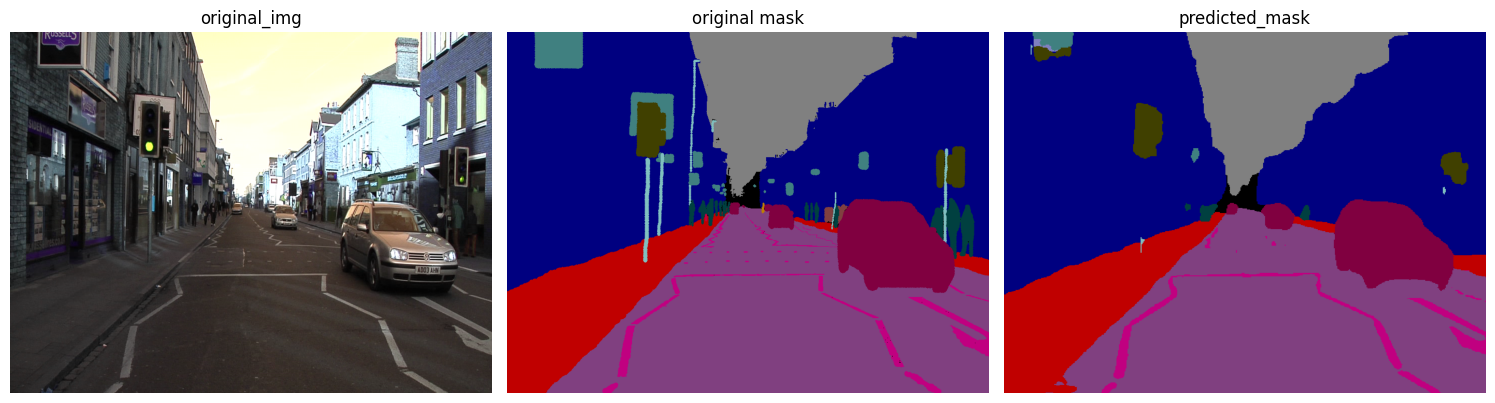

In [ ]:
# визуализируем один случайный пример
dict_example = curr_dataset[sample(list(range(len(curr_dataset))), 1)[0]]

img_orig = dict_example["orig_img"]
img_orig = cv2.cvtColor(img_orig, cv2.COLOR_RGB2BGR)
mask_orig = dict_example["orig_mask"]
mask_orig = cv2.cvtColor(mask_orig, cv2.COLOR_RGB2BGR)
img_preproc = dict_example["img_preproc"]
height, width, _ = dict_example["orig_shape"]

res_model.eval()
inputs = img_preproc.to(device)[np.newaxis, :, :, :]

with torch.no_grad():
  outputs = res_model(inputs)[0, :, :, :]
  pred = F.softmax(outputs, dim=0).cpu().numpy()

# pred_orig_size = np.resize(pred, (32, height, width))
pred_mask_2d = np.argmax(pred, axis=0)
pred_mask_2d = cv2.resize(pred_mask_2d, (width, height), interpolation=cv2.INTER_NEAREST)

pred_mask = np.zeros((height, width, 3)).astype(np.uint8)
for i in range(height):
  for j in range(width):
    curr_rgb = idx2rgb[pred_mask_2d[i, j]].astype(np.uint8)
    pred_mask[i, j, :] += curr_rgb


pred_mask = cv2.cvtColor(pred_mask.astype(np.uint8), cv2.COLOR_RGB2BGR)
plot_example(img_orig, mask_orig, pred_mask)


In [ ]:
# метрика meanIoU
# https://paperswithcode.com/sota/semantic-segmentation-on-camvid

# хороший пример
# https://www.kaggle.com/code/awsaf49/uwmgi-unet-train-pytorch
